# CS2545 - Term Mini-Project

### CS2545 - Data Science ###
### Winter, 2025 ###
### UNB, Fredericton ###

Refer to the read me for more details on the project.
</br>
</br>
</br>

## Data Loading & Cleaning Section

In [86]:
# comment out if not required :

# %pip install matplotlib
# %pip install pandas
# %pip install numpy
# %pip install plotly
# %pip install seaborn
# %pip install openpyxl

### Import Libraries & Save File paths for data

In [87]:
# Importing all the goodies
import pandas as pd
import numpy as np

# ploting imports
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import openpyxl as pxl
import matplotlib.ticker as ticker


# All Data to import using dataframes
population_Data_Path = "../data/population.csv"
Electricity_Generation_Data_Path = "../data/Electricity_Generation.xlsx"
Electricity_Interchange_Data_Path = "../data/Electricity_Interchange.xlsx"
Electricity_Capacity_Data_Path = "../data/Electricity_Capacity.xlsx"
End_Use_Demand_Data_Path = "../data/End_Use_Demand.xlsx"
End_Use_Prices_Data_Path = "../data/End_Use_Prices.xlsx"
energy_trade_canada_path = "../data/energy_trade_canada.xls"
Canadian_Climate_Normals_CANADA_Data_Path = "../data/1991-2020_Canadian_Climate_Normals_CANADA_Data.csv"

### Power Generation Data Set Cleaning 

In [88]:
generation_df = pd.read_excel(Electricity_Generation_Data_Path)

def clean_generation(df, start_row, province_name, num_rows = 8):

    header_row = start_row + 1
    data_rows = start_row + 2

    headers = df.iloc[header_row]
    block = df.iloc[data_rows : data_rows + num_rows].copy()
    block.columns = headers

    block = block.dropna(subset=[block.columns[0]])

    block = block.rename(columns={block.columns[0]: "Energy_Type"})
    block = block.melt(id_vars="Energy_Type", var_name="Year", value_name="GWh")

    block["Province"] = province_name
    block["Year"] = pd.to_numeric(block["Year"], errors="coerce")
    block["GWh"] = pd.to_numeric(block["GWh"], errors="coerce")

    block = block.dropna(subset=["Year", "GWh"])
    block["Year"] = block["Year"].astype(int)

    return block

provinces_generation = {
    "Canada": 5,
    "Newfoundland and Labrador": 16,
    "Prince Edward Island": 27,
    "Nova Scotia": 38,
    "New Brunswick": 49,
    "Quebec": 60,
    "Ontario": 71,
    "Manitoba": 82,
    "Alberta": 93,
    "British Columbia": 104,
    "Saskatchewan": 115,
    "Yukon": 126,
    "Northwest Territories": 137,
    "Nunavut": 148,
}

all_province_data = []

for province, start_row in provinces_generation.items():
    cleaned = clean_generation(generation_df, start_row, province)
    all_province_data.append(cleaned)


gen_clean = pd.concat(all_province_data, ignore_index=True)
quebec_df = gen_clean[gen_clean["Province"] == "Canada"]

gen_clean



,Energy_Type,Year,GWh,Province
0,Hydro / Wave / Tidal,2005,358380.80,Canada
1,Wind,2005,1453.41,Canada
2,Biomass / Geothermal,2005,6997.43,Canada
3,Solar,2005,0.00,Canada
4,Uranium,2005,86668.58,Canada
...,...,...,...,...
4341,Oil,2049,93.41,Nunavut
4342,Wind,2050,91.41,Nunavut
4343,Biomass / Geothermal,2050,197.79,Nunavut
4344,Solar,2050,43.61,Nunavut


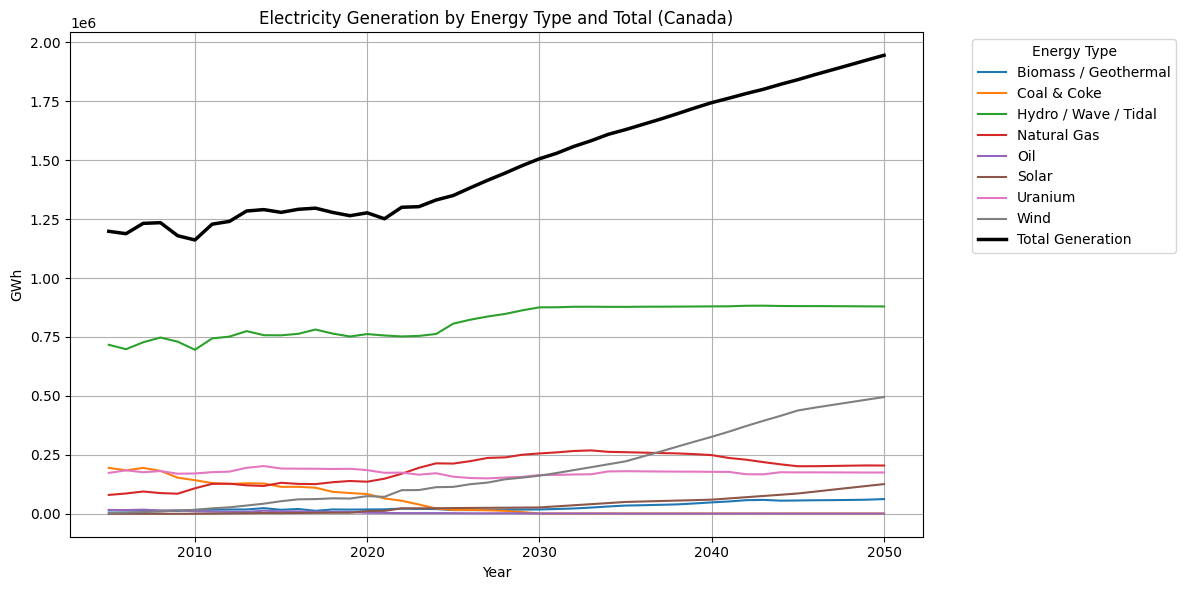

In [89]:
# 1. Total generation per year
total_generation = (
    gen_clean.groupby("Year", as_index=False)
    .agg({"GWh": "sum"})
    .rename(columns={"GWh": "Total_GWh"})
)

# 2. Generation by energy type per year
generation_by_type = (
    gen_clean.groupby(["Year", "Energy_Type"], as_index=False)
    .agg({"GWh": "sum"})
    .pivot(index="Year", columns="Energy_Type", values="GWh")
)

# 3. Plot all on the same figure
ax = generation_by_type.plot(
    figsize=(12, 6), 
    title="Electricity Generation by Energy Type and Total (Canada)",
    linewidth=1.5
)

# Add total generation as a bold black line
ax.plot(total_generation["Year"], total_generation["Total_GWh"], color="black", linewidth=2.5, label="Total Generation")

# Axis labels and legend
ax.set_xlabel("Year")
ax.set_ylabel("GWh")
ax.grid(True)
ax.legend(title="Energy Type", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


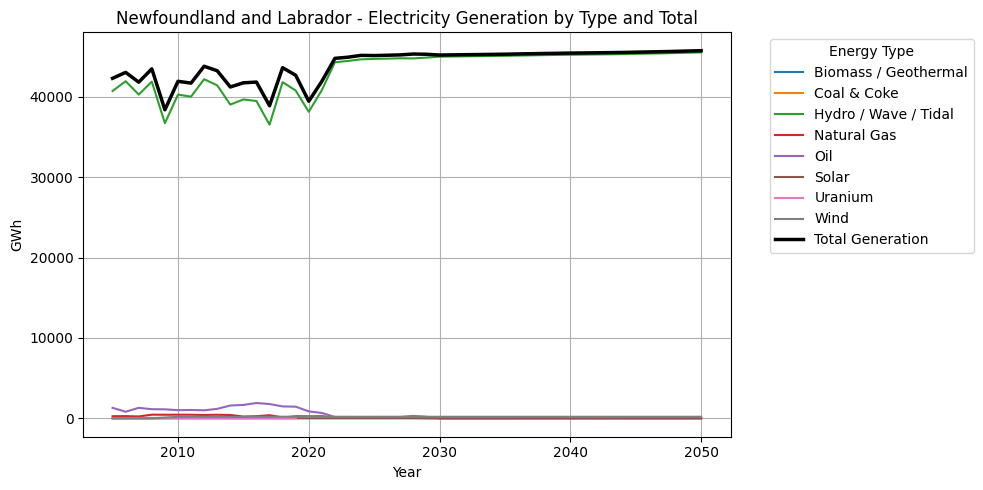

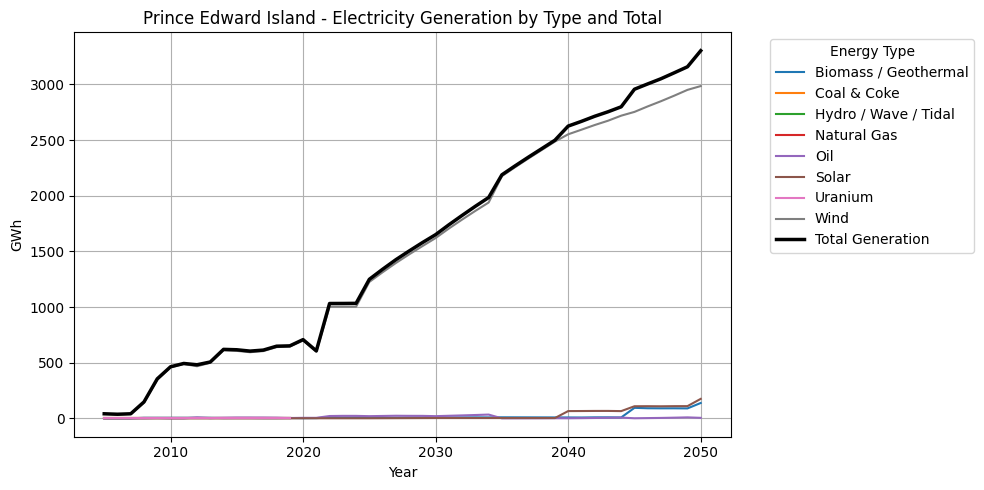

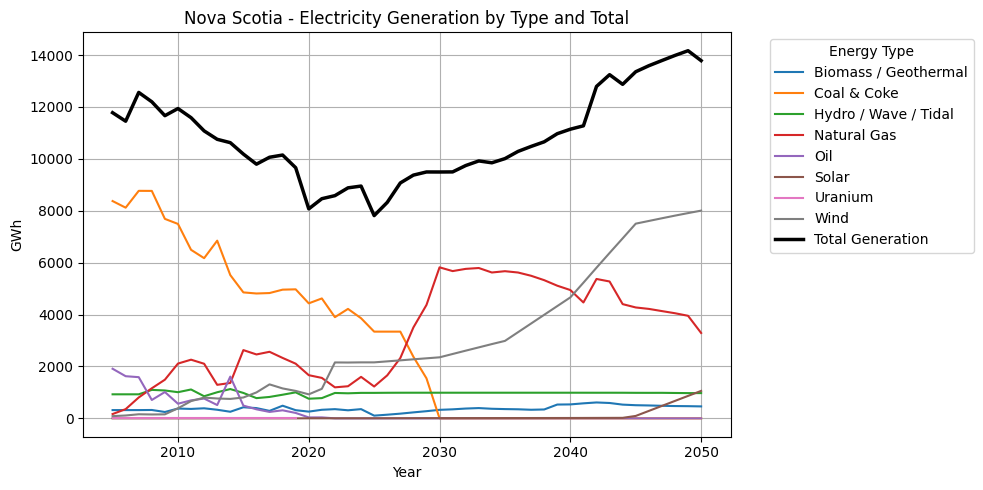

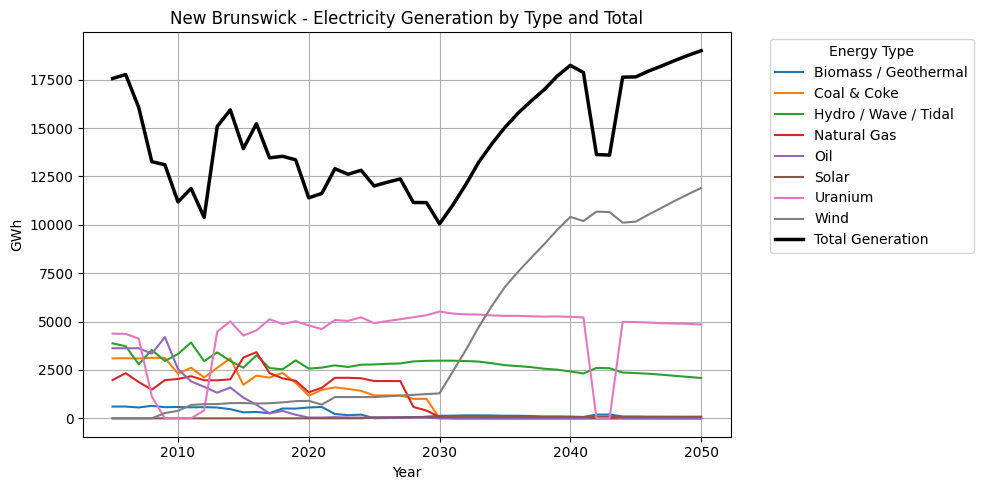

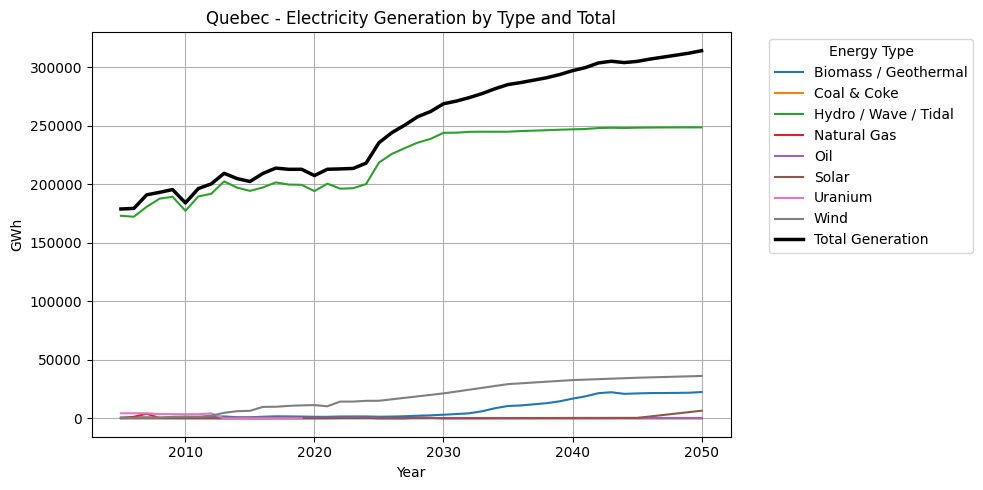

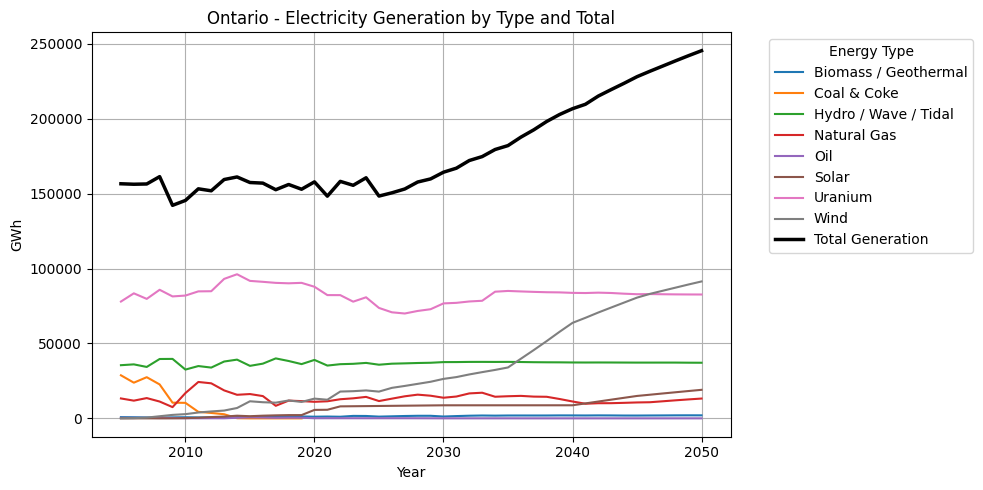

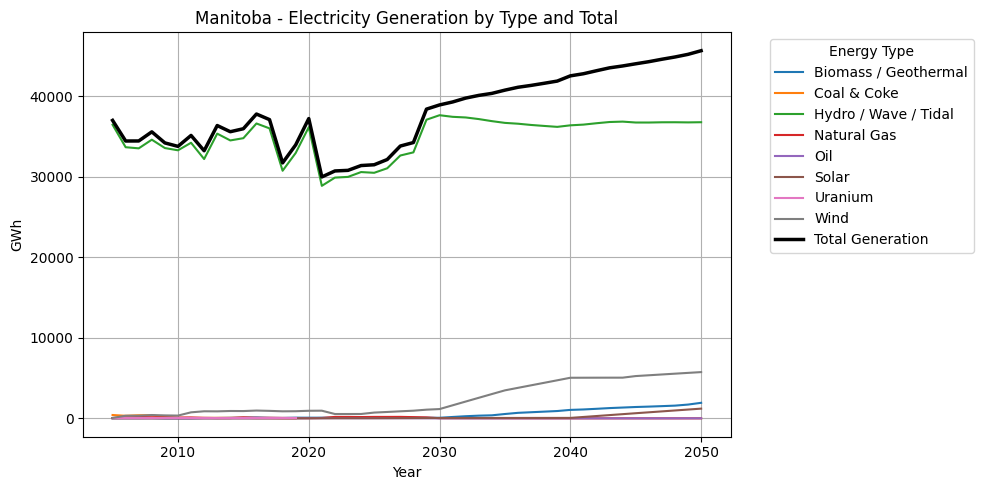

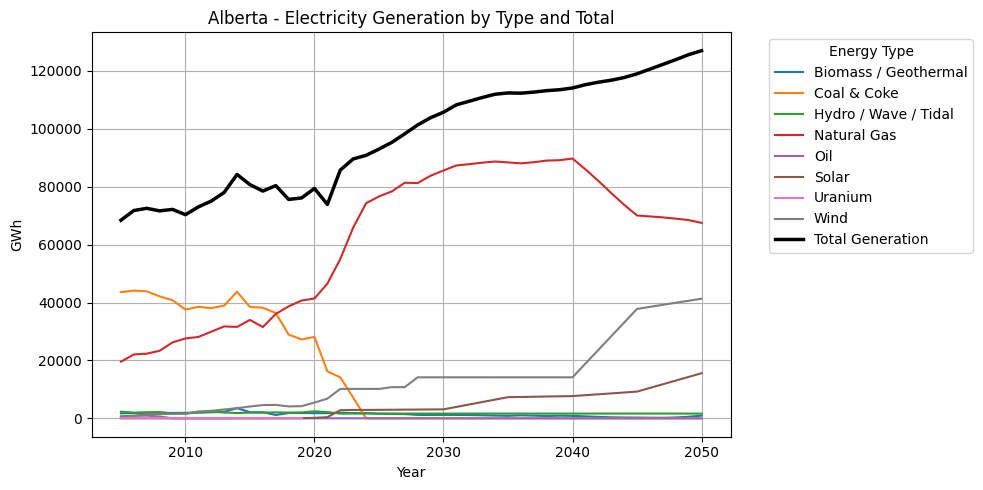

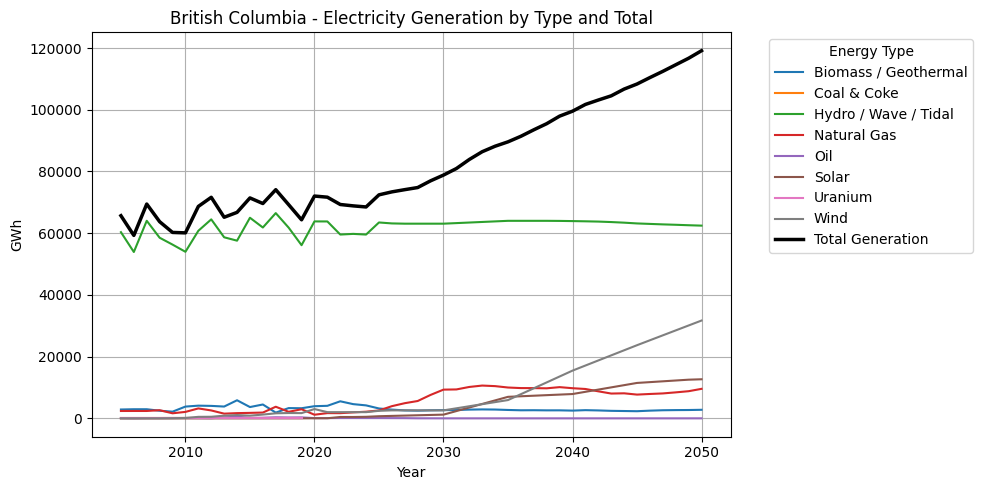

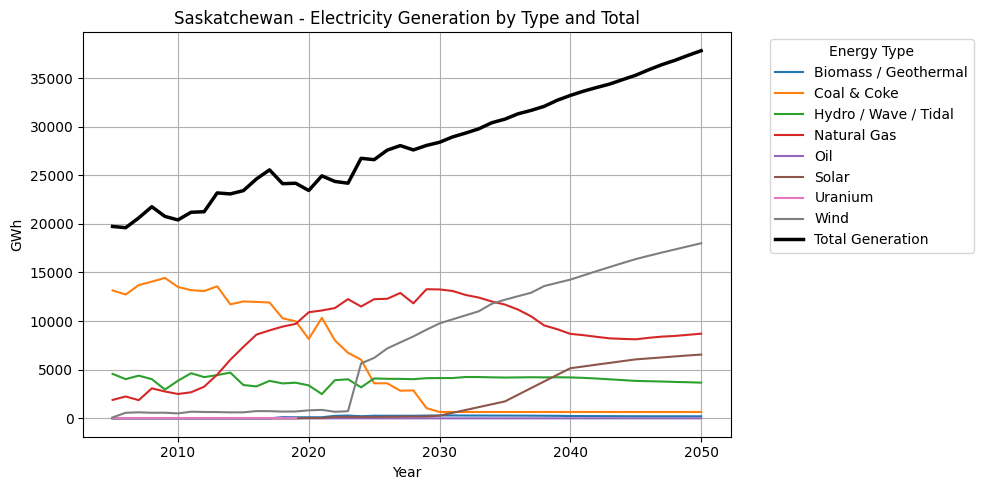

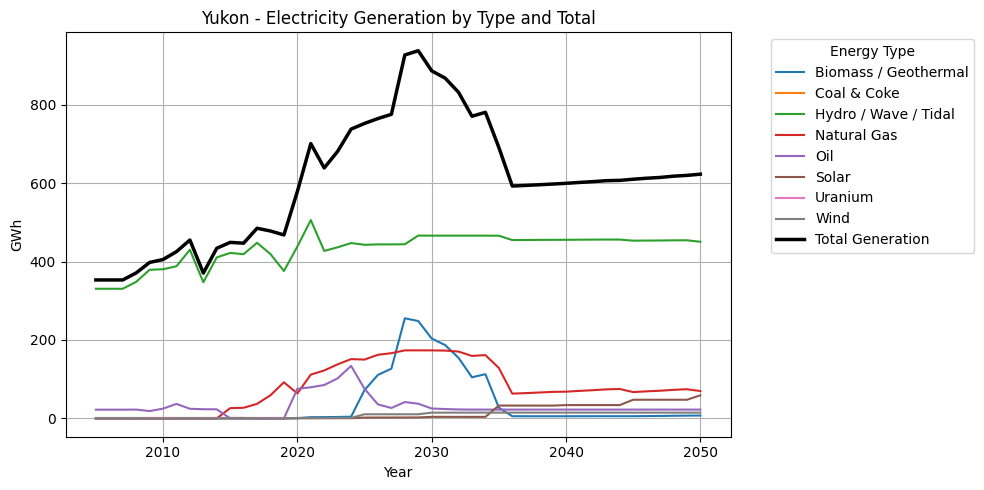

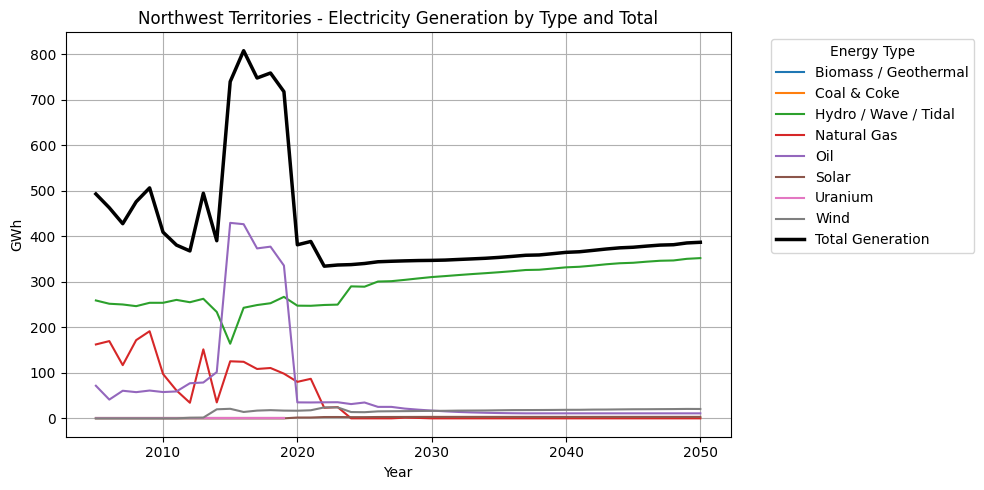

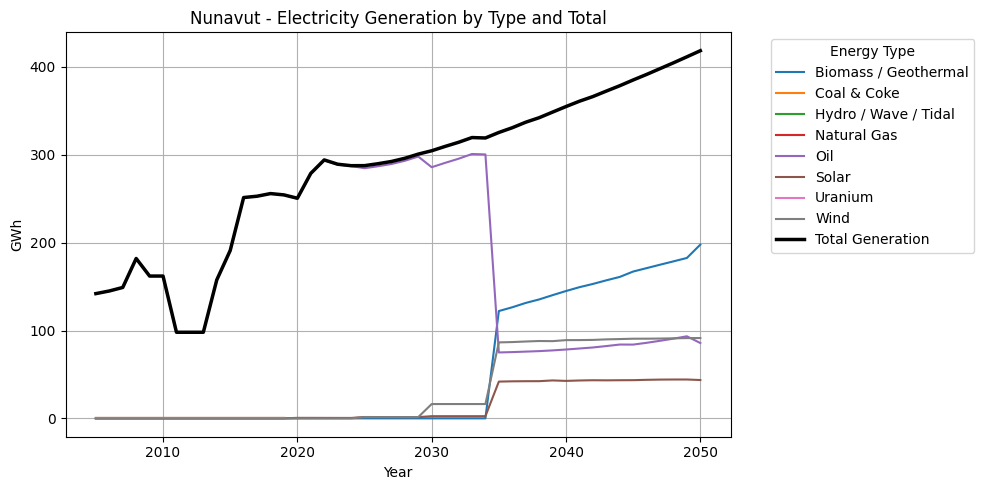

In [90]:
# Electricity Generation by Province and Energy Type

# List of provinces to include
# Uncomment the provinces you want to plot
provinces_to_plot = [
    "Newfoundland and Labrador",
    "Prince Edward Island",
    "Nova Scotia",
    "New Brunswick",
    "Quebec",
    "Ontario",
    "Manitoba",
    "Alberta",
    "British Columbia",
    "Saskatchewan",
    "Yukon",
    "Northwest Territories",
    "Nunavut",
    # "Canada",  # Uncomment if you also want to show national level here
]

for province in provinces_to_plot:
    province_df = gen_clean[gen_clean["Province"] == province]

    # Total generation per year
    total = (
        province_df.groupby("Year", as_index=False)
        .agg({"GWh": "sum"})
        .rename(columns={"GWh": "Total_GWh"})
    )

    # Generation by energy type
    by_type = (
        province_df.groupby(["Year", "Energy_Type"], as_index=False)
        .agg({"GWh": "sum"})
        .pivot(index="Year", columns="Energy_Type", values="GWh")
    )

    # Plot
    ax = by_type.plot(
        figsize=(10, 5), 
        title=f"{province} - Electricity Generation by Type and Total",
        linewidth=1.5
    )

    ax.plot(total["Year"], total["Total_GWh"], color="black", linewidth=2.5, label="Total Generation")
    ax.set_xlabel("Year")
    ax.set_ylabel("GWh")
    ax.grid(True)
    ax.legend(title="Energy Type", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout()
    plt.show()


### Power Capacity Data Set Cleaning

In [91]:
# Im using the same function from generation data
capacity_df = pd.read_excel(Electricity_Capacity_Data_Path)

provinces_cap = {
    "Canada": 5,
    "Newfoundland and Labrador": 16,
    "Prince Edward Island": 27,
    "Nova Scotia": 38,
    "New Brunswick": 49,
    "Quebec": 60,
    "Ontario": 71,
    "Manitoba": 82,
    "Alberta": 93,
    "British Columbia": 104,
    "Saskatchewan": 115,
    "Yukon": 126,
    "Northwest Territories": 137,
    "Nunavut": 148,
}

all_province_cap_data = []
for province, start_row in provinces_cap.items():
    cap_cleaned = clean_generation(capacity_df, start_row, province)
    all_province_cap_data.append(cap_cleaned)

cap_clean = pd.concat(all_province_cap_data, ignore_index=True)
# cap_clean

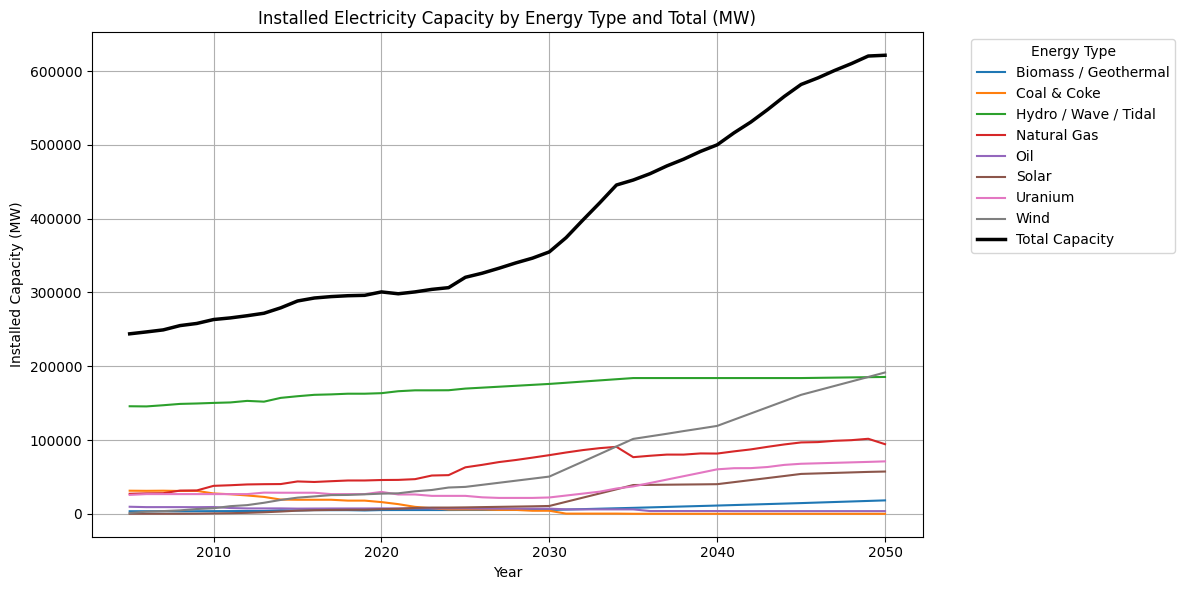

In [92]:
#total capacity graphing

# 1. Total capacity per year (all provinces, all types)
total_capacity = (
    cap_clean.groupby("Year", as_index=False)
    .agg({"GWh": "sum"})  # technically this column represents MW here
    .rename(columns={"GWh": "Total_MW"})
)

# 2. Capacity by energy type per year
capacity_by_type = (
    cap_clean.groupby(["Year", "Energy_Type"], as_index=False)
    .agg({"GWh": "sum"})  # again, values are MW
    .pivot(index="Year", columns="Energy_Type", values="GWh")
)

# 3. Plot all on one figure
ax = capacity_by_type.plot(
    figsize=(12, 6), 
    title="Installed Electricity Capacity by Energy Type and Total (MW)",
    linewidth=1.5
)

# Overlay total capacity as a bold black line
ax.plot(total_capacity["Year"], total_capacity["Total_MW"], color="black", linewidth=2.5, label="Total Capacity")

# Axis labels and formatting
ax.set_xlabel("Year")
ax.set_ylabel("Installed Capacity (MW)")
ax.grid(True)
ax.legend(title="Energy Type", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()



### Power Interchange Data Set Cleaning

### Power Interchange Data Set Cleaning

In [93]:
# Im gonna reuse the same function as well
interchange_df = pd.read_excel(Electricity_Interchange_Data_Path)
provinces_interchange = {
    "Canada": 4,
    "Newfoundland and Labrador": 13,
    "Prince Edward Island": 22,
    "Nova Scotia": 31,
    "New Brunswick": 40,
    "Quebec": 49,
    "Ontario": 58,
    "Manitoba": 67,
    "Alberta": 76,
    "British Columbia": 85,
    "Saskatchewan": 94,
}

all_province_interchange_data = []
for province, start_row in provinces_interchange.items():
    clean_interchange_block = clean_generation(interchange_df, start_row, province)
    all_province_interchange_data.append(clean_interchange_block)

interchange_clean = pd.concat(all_province_interchange_data, ignore_index=True)




# National stuff
# interchange_exports = get_total_national_exports(interchange_clean, year=2025)
# interchange_imports = get_total_national_imports(interchange_clean, year=2025)
# merged_interchange = pd.merge(interchange_exports, interchange_imports, on="Province", how="outer")

# Provincial stuff
# interchange_exports = get_total_provincal_exports(interchange_clean, year=2025)
# interchange_imports = get_total_provincal_imports(interchange_clean, year=2025)
# merged_interchange = pd.merge(interchange_exports, interchange_imports, on="Province", how="outer")


display(merged_interchange)



,Province,Total_Exports,Total_Imports
0,Alberta,5862.92,1586.33
1,British Columbia,911.14,5433.98
2,Canada,63624.35,63624.35
3,Manitoba,3090.01,623.28
4,New Brunswick,1669.23,6384.60
5,Newfoundland and Labrador,31381.89,0.57
6,Nova Scotia,519.65,5196.88
7,Ontario,6971.09,7144.31
8,Prince Edward Island,114.10,848.08
9,Quebec,12427.55,33355.55


### End use Price data set cleaning

In [94]:
prices_df = pd.read_excel(End_Use_Prices_Data_Path)

prices_provinces = {
    "Canada": 0,
    "Newfoundland and Labrador": 5,
    "Prince Edward Island": 11,
    "Nova Scotia": 17,
    "New Brunswick": 23,
    "Quebec": 29,
    "Ontario": 35,
    "Manitoba": 41,
    "Alberta": 47,
    "British Columbia": 53,
    "Saskatchewan": 59,
    "Yukon": 65,
    "Northwest Territories": 71,
    "Nunavut": 77,
}
year_filter = 2023
all_province_price_data = []

for province, start_row in prices_provinces.items():
    clean_block = clean_generation(prices_df, start_row, province, num_rows=3)
    all_province_price_data.append(clean_block)

prices_clean = pd.concat(all_province_price_data, ignore_index=True)
display(prices_clean)

# This function was used in both provincial and national data
def get_prices(df_prices, df_energy, filter_import_export="Total_Exports", year=2025):
    total_dollars = df_prices[(df_prices["Year"] == year) & (df_prices["Energy_Type"] == "Electricity")].copy()
    total_dollars["Cost_per_GWh"] = total_dollars["GWh"] * 1000  

    total_dollars = pd.merge(total_dollars, df_energy, on="Province", how="inner")
    total_dollars["Total_Profit"] = total_dollars["Cost_per_GWh"] * total_dollars[filter_import_export]
    return total_dollars[["Province", "Total_Profit"]]




,Energy_Type,Year,GWh,Province
0,Electricity,2005,37.59,Newfoundland and Labrador
1,Natural Gas,2005,20.88,Newfoundland and Labrador
2,Oil,2005,28.26,Newfoundland and Labrador
3,Electricity,2006,44.65,Newfoundland and Labrador
4,Natural Gas,2006,21.22,Newfoundland and Labrador
...,...,...,...,...
1789,Natural Gas,2049,12.11,Nunavut
1790,Oil,2049,32.28,Nunavut
1791,Electricity,2050,84.15,Nunavut
1792,Natural Gas,2050,12.14,Nunavut


### National Power Import and Exports Canada & US

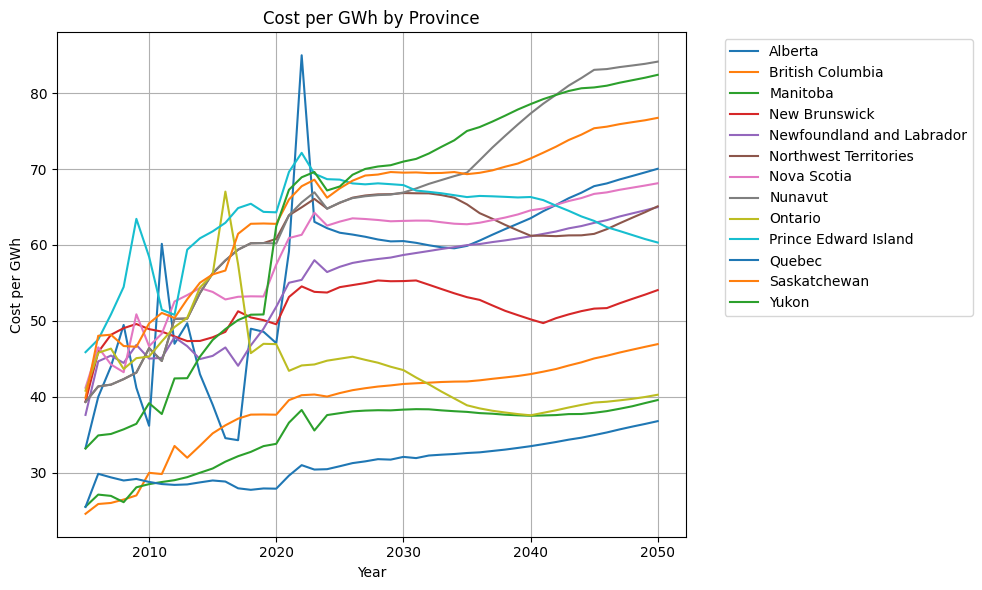

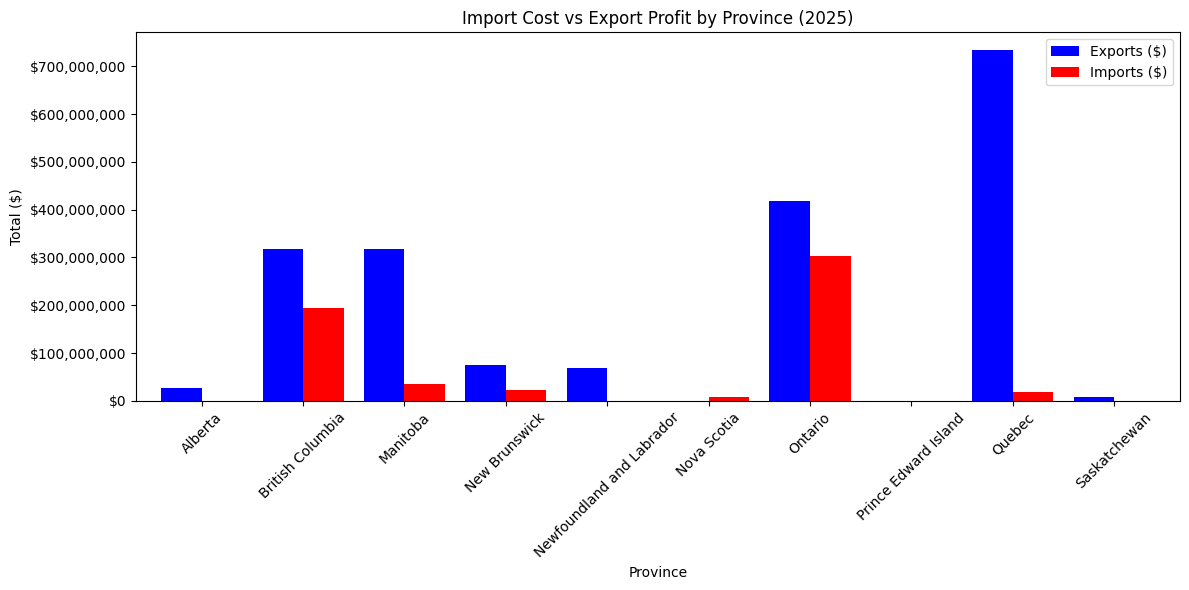

In [95]:
def get_total_national_imports(df, year=2025):

    total_imports = df[df["Year"] == year].copy()
    total_imports = total_imports[total_imports["Energy_Type"] == "Imports"]
    total_imports = total_imports.groupby("Province", as_index=False).agg({"GWh": "sum"})
    total_imports = total_imports.rename(columns={"GWh": "Total_Imports"})
    return total_imports

def get_total_national_exports(df, year=2025):

    total_exports = df[df["Year"] == year].copy()
    total_exports = total_exports[total_exports["Energy_Type"] == "Exports"]
    total_exports = total_exports.groupby("Province", as_index=False).agg({"GWh": "sum"})
    total_exports = total_exports.rename(columns={"GWh": "Total_Exports"})
    return total_exports

# National stuff
national_exports = get_total_national_exports(interchange_clean, year=year_filter)
national_imports = get_total_national_imports(interchange_clean, year=year_filter)
national_import_export = pd.merge(national_exports, national_imports, on="Province", how="outer")



def get_Price_by_Province(df_prices, year=year_filter):
    total_dollars = df_prices[df_prices["Energy_Type"] == "Electricity"].copy()
    return total_dollars

province_energy_prices = get_Price_by_Province(prices_clean, year=year_filter)
pivot = province_energy_prices.pivot(index="Year", columns="Province", values="GWh")
pivot.plot(kind="line", grid=True, figsize=(10, 6), title="Cost per GWh by Province", linewidth=1.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xlabel("Year")
plt.ylabel("Cost per GWh")
plt.tight_layout()
plt.show()




exports_total_profit = get_prices(prices_clean, national_import_export, filter_import_export="Total_Exports", year=year_filter)
imports_total_cost = get_prices(prices_clean, national_import_export, filter_import_export="Total_Imports", year=year_filter)


combined_trade = pd.merge(
    exports_total_profit.rename(columns={"Total_Profit": "Exports ($)"}),
    imports_total_cost.rename(columns={"Total_Profit": "Imports ($)"}),
    on="Province",
    how="outer"
).fillna(0)

# Optional: Remove "Canada" if it's just a summary row
combined_trade = combined_trade[combined_trade["Province"] != "Canada"]

ax = combined_trade.plot(
    x="Province",
    kind="bar",
    figsize=(12, 6),
    color=["blue", "red"],
    width=0.8,
    title="Import Cost vs Export Profit by Province (2025)"
)

plt.ylabel("Total ($)")
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}')) 
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()









### Provincial Power Import and Exports 

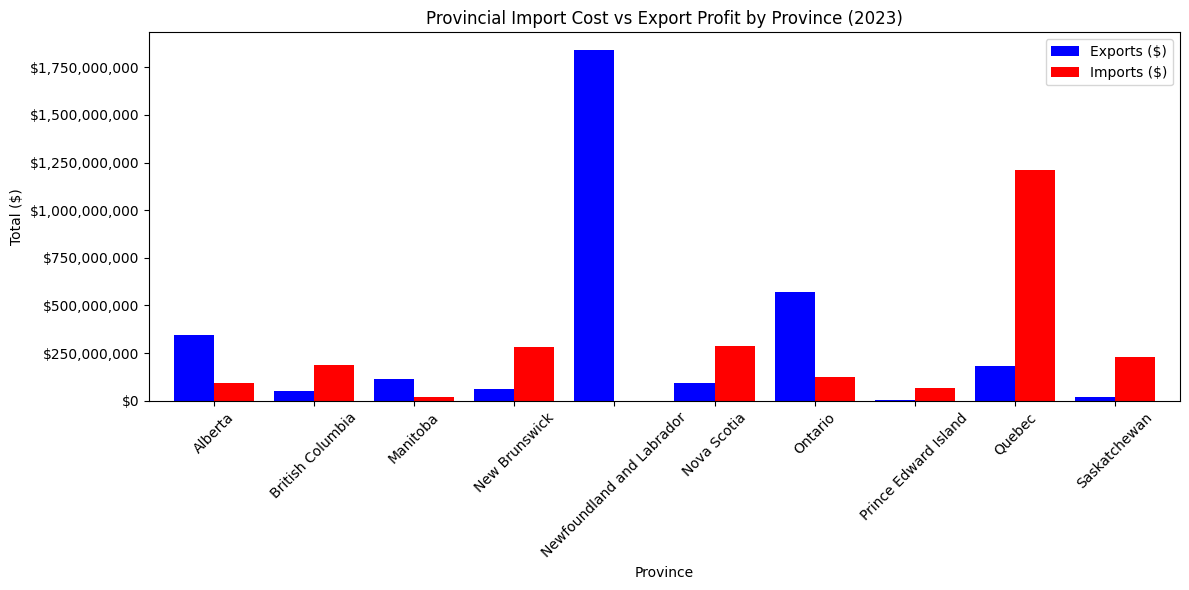

In [96]:
def get_total_provincal_totals(df, year=2025, filter_import_export="Interprovincial Out-Flows"):

    total_exports = df[df["Year"] == year].copy()
    total_exports = total_exports[total_exports["Energy_Type"] == filter_import_export]
    total_exports = total_exports.groupby("Province", as_index=False).agg({"GWh": "sum"})
    return total_exports.rename(columns={"GWh": filter_import_export})


# Provincial stuff
provincial_exports = get_total_provincal_totals(interchange_clean, year=year_filter, filter_import_export="Interprovincial Out-Flows")
provincial_imports = get_total_provincal_totals(interchange_clean, year=year_filter, filter_import_export="Interprovincial In-Flows")
provincial_imports_exports = pd.merge(provincial_exports, provincial_imports, on="Province", how="outer")

provincial_exports_profit = get_prices(prices_clean, provincial_imports_exports, filter_import_export="Interprovincial Out-Flows", year=year_filter)
provincial_imports_cost = get_prices(prices_clean, provincial_imports_exports, filter_import_export="Interprovincial In-Flows", year=year_filter)


# Merge export and import values into one DataFrame
combined_provincial_trade = pd.merge(
    provincial_exports_profit.rename(columns={"Total_Profit": "Exports ($)"}),
    provincial_imports_cost.rename(columns={"Total_Profit": "Imports ($)"}),
    on="Province",
    how="outer"
).fillna(0)

# Optional: remove Canada if it's in there
combined_provincial_trade = combined_provincial_trade[combined_provincial_trade["Province"] != "Canada"]

# Grouped bar chart to compare exports vs imports
ax = combined_provincial_trade.plot(
    x="Province",
    kind="bar",
    figsize=(12, 6),
    color=["blue", "red"],
    width=0.8,
    title=f"Provincial Import Cost vs Export Profit by Province ({year_filter})"
)
plt.ylabel("Total ($)")
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))  # Format as dollars with commas
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()







### End use demand data set cleaning

In [97]:
demand_df = pd.read_excel(End_Use_Demand_Data_Path)
# print(demand_df.columns)
# demand_df.head(20)    

# def clean_end_used_demand(demand_df, sector_blocks, num_rows=7):
#     all_sectors = []

#     for sector, start_row in sector_blocks.items():
#         header_row = start_row + 1
#         data_start = start_row + 2

#         headers = demand_df.iloc[header_row].dropna().values
#         if len(headers) == 0:
#             print(f"Skipped sector '{sector}' — no valid headers at row {header_row}")
#             continue

#         block = demand_df.iloc[data_start : data_start + num_rows, :len(headers)].copy()
#         block.columns = headers

#         block = block.dropna(subset=[block.columns[0]])
#         block = block.rename(columns={block.columns[0]: "Energy_Type"})

#         block = block.melt(id_vars="Energy_Type", var_name="Year", value_name="PJ")
#         block["Sector"] = sector
#         block["Year"] = pd.to_numeric(block["Year"], errors="coerce")
#         block["PJ"] = pd.to_numeric(block["PJ"], errors="coerce")

#         block = block.dropna(subset=["Year", "PJ"])
#         block["Year"] = block["Year"].astype(int)

#         all_sectors.append(block)

#     return pd.concat(all_sectors, ignore_index=True) if all_sectors else pd.DataFrame()

sector_blocks = {
    "Total End-Use": 5,
    "Residential": 14,
    "Commercial": 26,        # Corrected based on screenshot
    "Industrial": 35,        # You may need to confirm these as well
    "Transportation": 44
}

# # Use updated function
# demand_clean = clean_end_used_demand(demand_df, sector_blocks, num_rows=20)
# display(demand_clean)

def clean_end_use_demand(df, sector_blocks, num_rows=7):
    all_sectors = []

    for sector, start_row in sector_blocks.items():
        header_row = start_row + 1
        data_start = start_row + 2

        headers = df.iloc[header_row]
        block = df.iloc[data_start : data_start + num_rows].copy()
        block.columns = headers

        block = block.dropna(subset=[block.columns[0]])
        block = block.rename(columns={block.columns[0]: "Energy_Type"})

        block = block.melt(id_vars="Energy_Type", var_name="Year", value_name="PJ")
        block["Sector"] = sector
        block["Year"] = pd.to_numeric(block["Year"], errors="coerce")
        block["PJ"] = pd.to_numeric(block["PJ"], errors="coerce")

        block = block.dropna(subset=["Year", "PJ"])
        block["Year"] = block["Year"].astype(int)

        all_sectors.append(block)

    return pd.concat(all_sectors, ignore_index=True)

#old sector blocks that are not currently working
# sector_blocks = {
#     "Total End-Use": 5,
#     "Residential": 14,
#     "Commercial": 23,
#     "Industrial": 32,
#     "Transportation": 41
# }

demand_clean = clean_end_use_demand(demand_df, sector_blocks, num_rows=20)
# display(demand_clean)
print(demand_clean["Sector"].unique())
demand_clean = clean_end_use_demand(demand_df, sector_blocks, num_rows=20)
print(demand_clean["Sector"].value_counts())


['Total End-Use' 'Commercial' 'Industrial']
Sector
Industrial       828
Total End-Use    736
Commercial       736
Name: count, dtype: int64


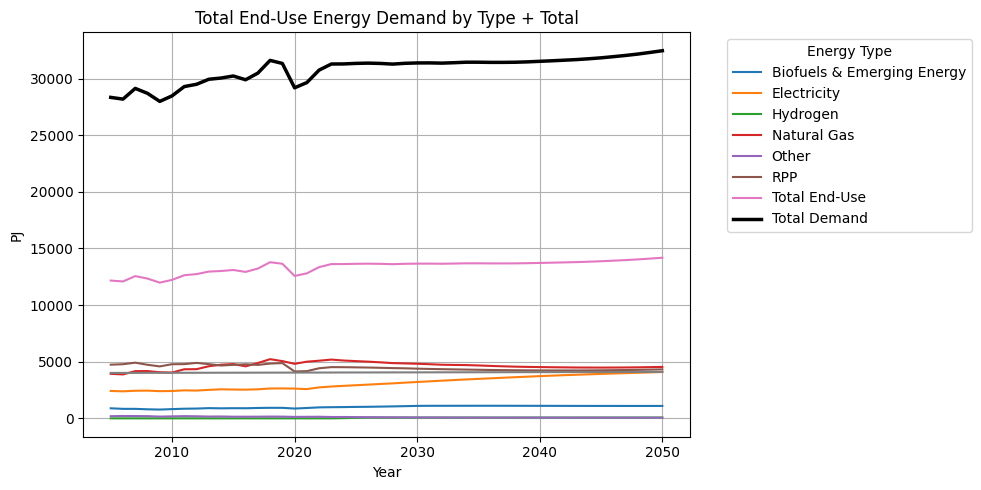

TypeError: no numeric data to plot

In [98]:
# graph end use demand by sector

# Toggle which sectors to graph — comment out to skip
sectors_to_plot = [
    "Total End-Use",
    "Residential",
    "Commercial",
    "Industrial",
    "Transportation"
]

for sector in sectors_to_plot:
    sector_df = demand_clean[demand_clean["Sector"] == sector]

    # Total demand over time for the sector
    total = (
        sector_df.groupby("Year", as_index=False)
        .agg({"PJ": "sum"})
        .rename(columns={"PJ": "Total_PJ"})
    )

    # Demand by energy type
    by_type = (
        sector_df.groupby(["Year", "Energy_Type"], as_index=False)
        .agg({"PJ": "sum"})
        .pivot(index="Year", columns="Energy_Type", values="PJ")
    )

    # Plot
    ax = by_type.plot(
        figsize=(10, 5),
        title=f"{sector} Energy Demand by Type + Total",
        linewidth=1.5
    )

    ax.plot(total["Year"], total["Total_PJ"], color="black", linewidth=2.5, label="Total Demand")
    ax.set_xlabel("Year")
    ax.set_ylabel("PJ")
    ax.grid(True)
    ax.legend(title="Energy Type", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout()
    plt.show()


### End use Price data set cleaning

In [ ]:
# end use prices graphing per province 

# Provinces you want to visualize — comment out to toggle
provinces_to_plot = [
    "Newfoundland and Labrador",
    "Prince Edward Island",
    "Nova Scotia",
    "New Brunswick",
    "Quebec",
    "Ontario",
    "Manitoba",
    "Alberta",
    "British Columbia",
    "Saskatchewan",
    "Yukon",
    "Northwest Territories",
    "Nunavut",
]

for province in provinces_to_plot:
    province_df = prices_clean[prices_clean["Province"] == province]

    # Pivot for line plotting by energy type
    pivot = province_df.pivot(index="Year", columns="Energy_Type", values="GWh")

    # Plot
    ax = pivot.plot(
        figsize=(10, 5),
        title=f"{province} - Residential Energy Prices by Type ($/GJ)",
        linewidth=1.5
    )

    ax.set_xlabel("Year")
    ax.set_ylabel("Price ($/GJ)")
    ax.grid(True)
    ax.legend(title="Energy Type", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout()
    plt.show()


### Climate Data Cleaning Function

In [ ]:
climate_df = pd.read_csv(Canadian_Climate_Normals_CANADA_Data_Path, sep=",")

def clean_climate_data(df):

    df.columns = df.columns.str.strip()
    df_yearly = df.copy()
    df_yearly = df_yearly.rename(columns={
        "LOCATION_NAME": "Location",
        "PROVINCE_OR_TERRITORY": "Province",
        "NORMALS_ELEMENT": "Element",
        "Year": "Value"
    })

    df_yearly["Value"] = pd.to_numeric(df_yearly["Value"], errors="coerce")
    df_yearly = df_yearly.dropna(subset=["Value"])

    df_yearly = df_yearly[~df_yearly["Element"].str.contains("Date|StdDev|Extreme", na=False)]

    return df_yearly[["Location", "Province", "PERIOD_OF_RECORD", "ELEMENT_GROUP", "Element", "Value"]]


climate_clean = clean_climate_data(climate_df)
climate_clean



,Location,Province,PERIOD_OF_RECORD,ELEMENT_GROUP,Element,Value
0,BANFF,AB,Normal,Temperature,Daily Average (°C),2.7
2,BANFF,AB,Normal,Temperature,Daily Maximum (°C),8.9
3,BANFF,AB,Normal,Temperature,Daily Minimum (°C),-3.5
28,BANFF,AB,Normal,Precipitation,Rainfall (mm),295.7
29,BANFF,AB,Normal,Precipitation,Snowfall (cm),183.8
...,...,...,...,...,...,...
69063,WHITEHORSE,YT,Long-Term,Frost-Free,Probability of frost-free period equal to or l...,76.0
69064,WHITEHORSE,YT,Long-Term,Frost-Free,Probability of frost-free period equal to or l...,85.0
69065,WHITEHORSE,YT,Long-Term,Frost-Free,Probability of frost-free period equal to or l...,91.0
69066,WHITEHORSE,YT,Long-Term,Frost-Free,Probability of frost-free period equal to or l...,96.0


### Population Data Set Cleaning

In [ ]:

def clean_population_database_format(filepath):

    df = pd.read_csv(filepath)

    df = df[["REF_DATE", "GEO", "VALUE"]].rename(columns={
        "REF_DATE": "Date",
        "GEO": "Province",
        "VALUE": "Population"
    })

    df = df.dropna(subset=["Population"])

    df["Date"] = pd.to_datetime(df["Date"])
    df["Year"] = df["Date"].dt.year

    df_yearly = (
        df.groupby(["Province", "Year"], as_index=False)
        .agg({"Population": "mean"})
    )

    return df_yearly

population_yearly_df = clean_population_database_format(population_Data_Path)
population_yearly_df





,Province,Year,Population
0,Alberta,2005,3310477.00
1,Alberta,2006,3411010.00
2,Alberta,2007,3502798.25
3,Alberta,2008,3582868.25
4,Alberta,2009,3667767.00
...,...,...,...
289,Yukon,2021,42672.25
290,Yukon,2022,43653.75
291,Yukon,2023,45141.00
292,Yukon,2024,46485.25


## Data Proccessing Section

### Analyze energy production in different regions of Canada

,Province,Year,GWh
112,Canada,2025,675104.29
526,Quebec,2025,235592.46
434,Ontario,2025,148402.45
20,Alberta,2025,93005.91
66,British Columbia,2025,72423.34
250,Newfoundland and Labrador,2025,45147.34
158,Manitoba,2025,31474.71
572,Saskatchewan,2025,26603.29
204,New Brunswick,2025,12011.32
342,Nova Scotia,2025,7814.09


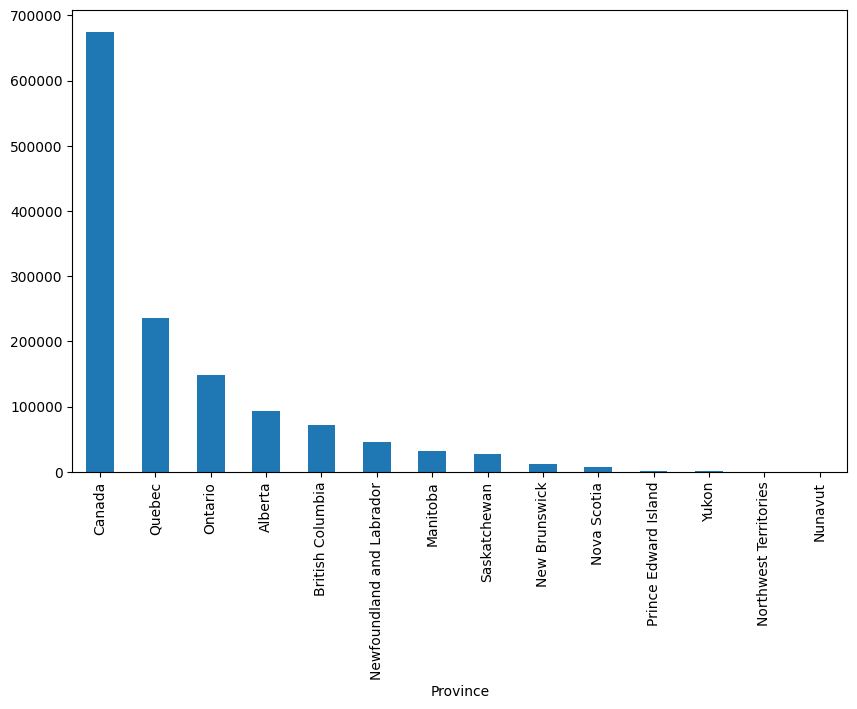

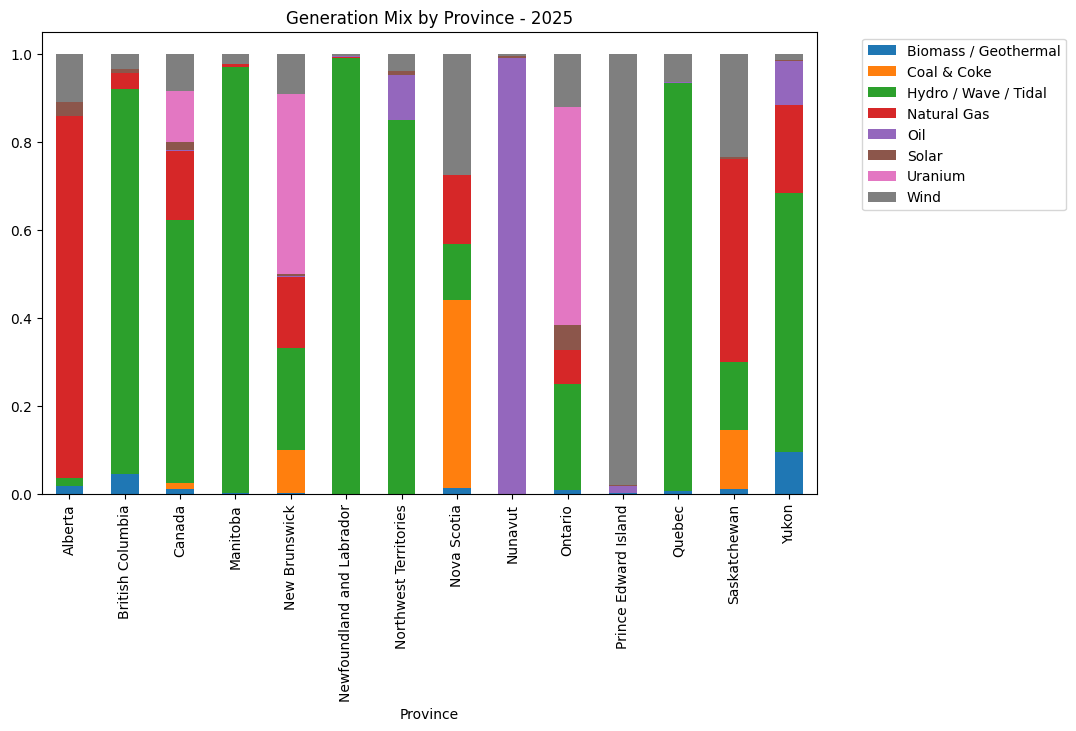

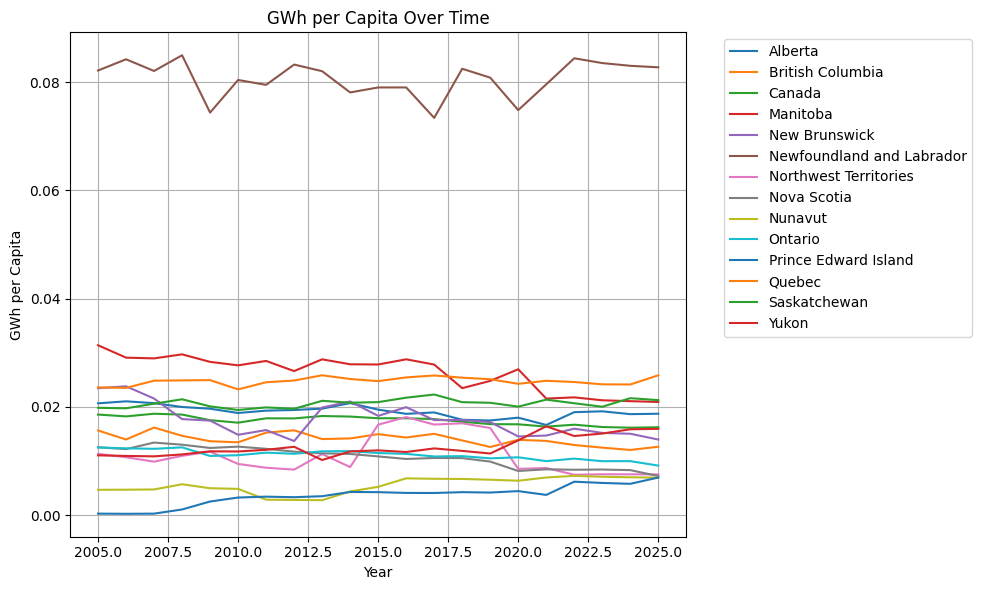

In [ ]:
# Use generation_df, capacity_df, and population_yearly_df

# Legend
# - GWh = Gigawatt hour
# - MW = Megawatt

# TODO - Whats needed to be done 

# Total GWh per province per year
def get_total_gwh_per_province(df):
    return df.groupby(["Province", "Year"], as_index=False).agg({"GWh": "sum"})

# Normalize data 

# Per Capita (GWh/population)
def get_per_capita_GWh(df_gwh, df_population):

    merged_df = pd.merge(df_gwh, df_population, on=["Province", "Year"], how="inner")    
    merged_df["GWh_per_Capita"] = merged_df["GWh"] / merged_df["Population"]
    
    return merged_df[["Province", "Year", "GWh_per_Capita"]]

# Per MW of capacity (GWh/MW)
def get_per_GWh_MW(df_gwh, df_mw):
    total_mw = df_mw.groupby(["Province", "Year"], as_index=False).agg({"GWh": "sum"})
    total_mw = total_mw.rename(columns={"GWh": "MW"})
    merged_df = pd.merge(df_gwh, total_mw, on=["Province", "Year"], how="inner")
    merged_df["GWh_per_MW"] = merged_df["GWh"] / merged_df["MW"]
    return merged_df[["Province", "Year", "GWh_per_MW"]]


total_gwh_per_province = get_total_gwh_per_province(gen_clean)
per_capita = get_per_capita_GWh(total_gwh_per_province, population_yearly_df)
per_capita = get_per_GWh_MW(total_gwh_per_province, cap_clean)


# Show generation mix % of All type
def get_generation_mix(df):
    generation_mix = df.groupby(["Province", "Year", "Energy_Type"], as_index=False).agg({"GWh": "sum"})
    generation_mix["GWh"] = generation_mix["GWh"] / generation_mix.groupby(["Province", "Year"])["GWh"].transform("sum")
    return generation_mix

generation_mix = get_generation_mix(gen_clean)

# Potential stuff to show data 

display_barChar_GHw_per_Prov = True
display_Stacked_barChar_GHw_per_Prov = True
display_lineChar_GHw_per_Capita = True
year_wanted = 2025 

# - Bar chart of GWh produced per province

if display_barChar_GHw_per_Prov:
    gwh_year = total_gwh_per_province[total_gwh_per_province["Year"] == year_wanted]
    gwh_year = gwh_year.sort_values("GWh", ascending=False)
    gwh_year.plot.bar(x="Province", y="GWh", figsize=(10, 6), legend=False)
    display(gwh_year)

# - Stacked bar chart of energy types

if display_Stacked_barChar_GHw_per_Prov:
    mix_year = generation_mix[generation_mix["Year"] == year_wanted]
    mix_pivot = mix_year.pivot(index="Province", columns="Energy_Type", values="GWh")
    mix_pivot.plot(kind="bar", stacked=True, figsize=(10, 6), title=f"Generation Mix by Province - {year_wanted}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")


# - Line chart of GWh per capita over time 

if display_lineChar_GHw_per_Capita:

    per_capita_line = get_per_capita_GWh(total_gwh_per_province, population_yearly_df)
    pivot = per_capita_line.pivot(index="Year", columns="Province", values="GWh_per_Capita")

    pivot.plot(kind="line", grid=True, figsize=(10, 6),  title="GWh per Capita Over Time")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.xlabel("Year")
    plt.ylabel("GWh per Capita")

    plt.tight_layout()
    plt.show()




### Analyze energy usage in different regions of Canada.

In [100]:
# Use demand_df, and population_yearly_df
demand_clean.columns

# TODO - Whats needed to be done 
demand_clean["GWh"] = demand_clean["PJ"] * 277.778


# Total GWh demand per province per year (Total End-Use only)
def get_total_demand_per_year(df):
    total_use = df[df["Sector"] == "Total End-Use"]
    return total_use.groupby("Year", as_index=False).agg({"GWh": "sum"})


# Normalize by population (GWh per capita)
def get_demand_per_capita_country(df_demand, df_population):
    canada_pop = df_population[df_population["Province"] == "Canada"]
    merged = pd.merge(df_demand, canada_pop, on="Year", how="inner")
    merged["GWh_per_Capita"] = merged["GWh"] / merged["Population"]
    return merged[["Year", "GWh_per_Capita"]]


# Compare demand vs generation (Self-sufficiency)
def get_self_sufficiency_country(df_generation, df_demand):
    canada_gen = df_generation[df_generation["Province"] == "Canada"]
    merged = pd.merge(canada_gen, df_demand, on="Year", how="inner", suffixes=("_gen", "_demand"))
    merged["Self_Sufficiency"] = merged["GWh_gen"] / merged["GWh_demand"]
    return merged[["Year", "Self_Sufficiency"]]




total_demand_country = get_total_demand_per_year(demand_clean)
demand_per_capita_country = get_demand_per_capita_country(total_demand_country, population_yearly_df)
self_sufficiency_country = get_self_sufficiency_country(total_gwh_per_province, total_demand_country)




display_bar_demand_per_province = True
display_map_demand_per_capita = True
display_self_sufficiency_bar = True
year_wanted = 2025

# demand_year = total_demand_per_province[total_demand_per_province["Year"] == year_wanted]
# demand_per_capita_year = demand_per_capita[demand_per_capita["Year"] == year_wanted]
# self_sufficiency_year = self_sufficiency[self_sufficiency["Year"] == year_wanted]



# Potential stuff to show data 
# Bar chart: total demand
if display_bar_demand_per_province:
    demand_year = demand_year.sort_values("GWh", ascending=False)
    demand_year.plot.bar(x="Province", y="GWh", figsize=(10, 6), legend=False,
                         title=f"Total Electricity Demand per Province - {year_wanted}")

# Bar chart: per capita demand
if display_map_demand_per_capita:
    demand_per_capita_year = demand_per_capita_year.sort_values("GWh_per_Capita", ascending=False)
    demand_per_capita_year.plot.bar(x="Province", y="GWh_per_Capita", figsize=(10, 6), legend=False,
                                    title=f"Per Capita Demand by Province - {year_wanted}")

# Bar chart: self-sufficiency
if display_self_sufficiency_bar:
    self_sufficiency_year = self_sufficiency_year.sort_values("Self_Sufficiency", ascending=False)
    ax = self_sufficiency_year.plot.bar(x="Province", y="Self_Sufficiency", figsize=(10, 6), legend=False,
                                        title=f"Energy Self-Sufficiency by Province - {year_wanted}")
    ax.axhline(1.0, color="red", linestyle="--", linewidth=1)  # 100% self-sufficiency line


NameError: name 'population_yearly_df' is not defined

### Analyze energy usage in different sectors in Canada.

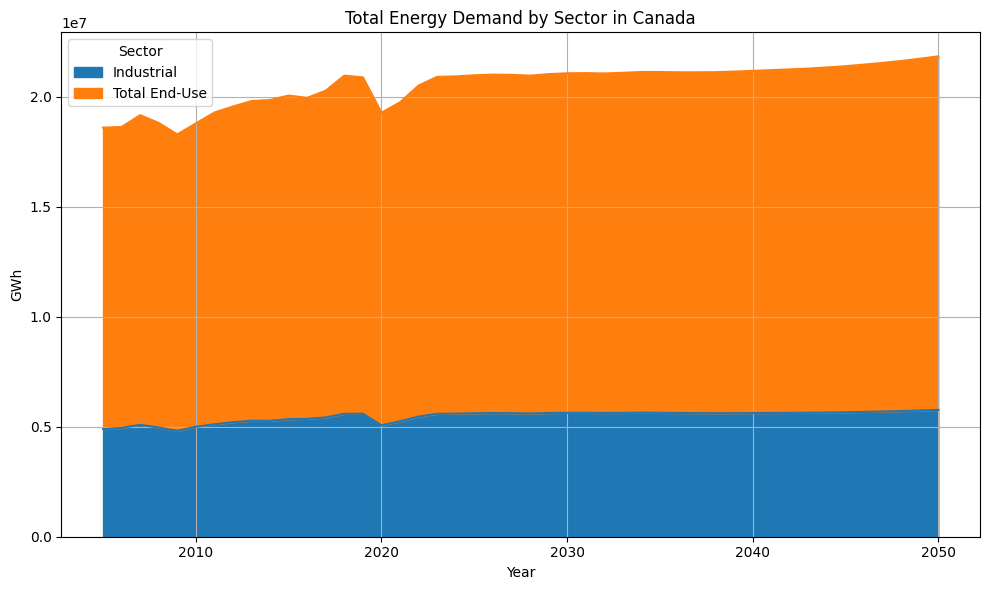

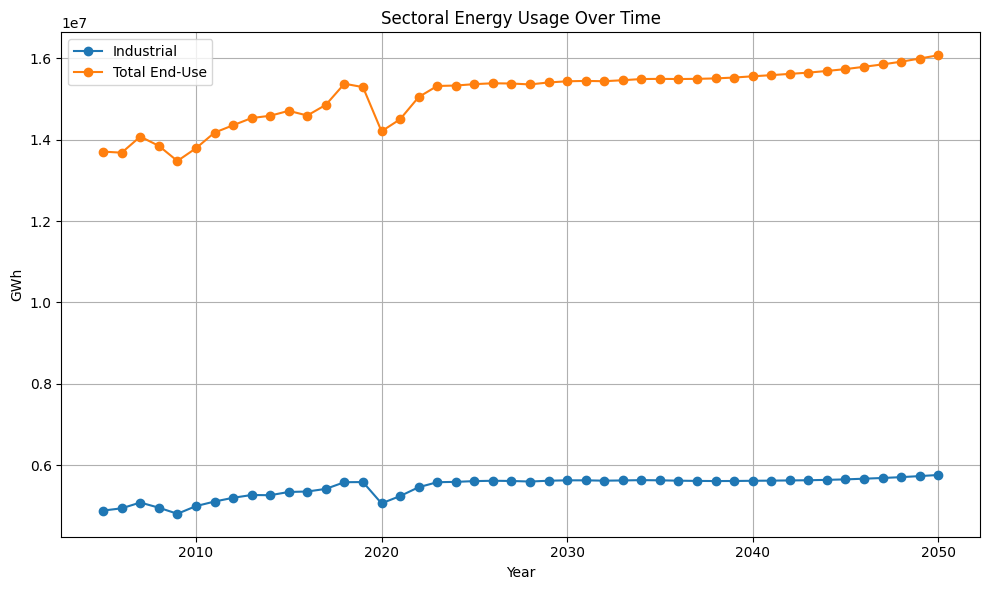

In [ ]:
# Step 1: Clean it first
demand_clean = clean_end_use_demand(demand_df, sector_blocks, num_rows=50)

# Step 2: Convert PJ to GWh
demand_clean["GWh"] = demand_clean["PJ"] * 277.778

# Step 3: Filter Year range
demand_clean["Year"] = pd.to_numeric(demand_clean["Year"], errors="coerce")
demand_clean = demand_clean.dropna(subset=["Year"])
demand_clean = demand_clean[demand_clean["Year"] >= 2000]
demand_clean["Year"] = demand_clean["Year"].astype(int)

# Step 4: Sectoral analysis
def get_sector_trends(df):
    return df.groupby(["Sector", "Year"], as_index=False).agg({"GWh": "sum"})

# Flags for what to show
display_sector_area_total = True
display_line_per_sector = True

# Area chart
if display_sector_area_total:
    sector_trend = get_sector_trends(demand_clean)
    pivot = sector_trend.pivot(index="Year", columns="Sector", values="GWh")
    pivot.plot(kind="area", stacked=True, figsize=(10, 6), title="Total Energy Demand by Sector in Canada")
    plt.ylabel("GWh")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Line chart
if display_line_per_sector:
    sector_trend = get_sector_trends(demand_clean)
    sectors = sector_trend["Sector"].unique()

    plt.figure(figsize=(10, 6))
    for sector in sectors:
        sector_data = sector_trend[sector_trend["Sector"] == sector]
        plt.plot(sector_data["Year"], sector_data["GWh"], marker="o", label=sector)

    plt.title("Sectoral Energy Usage Over Time")
    plt.xlabel("Year")
    plt.ylabel("GWh")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Analyze price difference in different regions.

['Energy_Type', 'Year', 'GWh', 'Province']


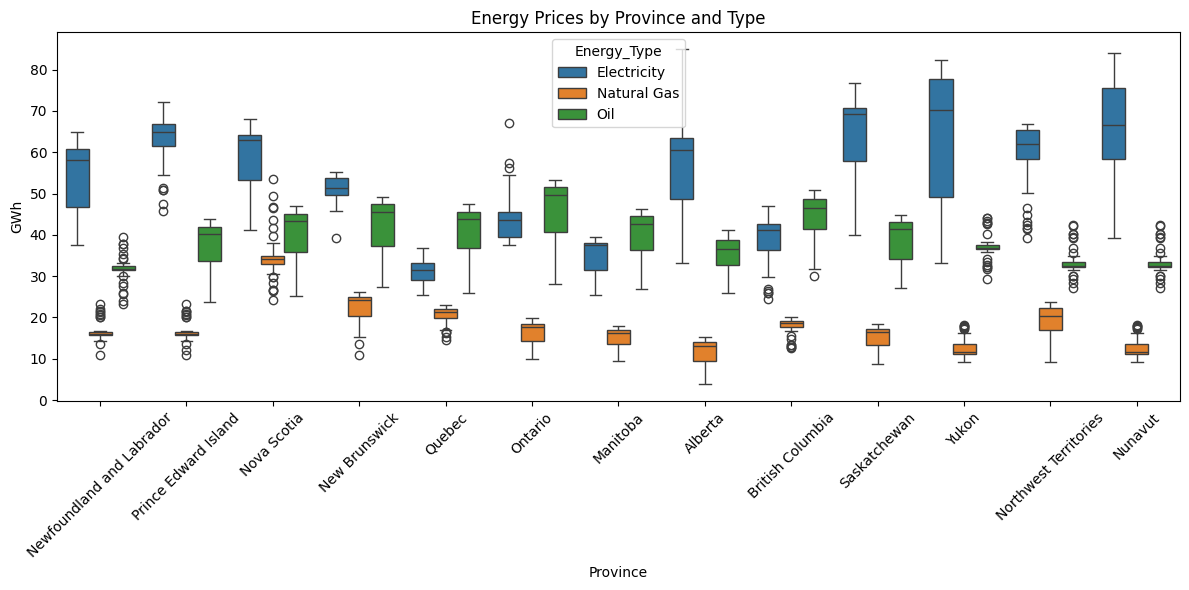

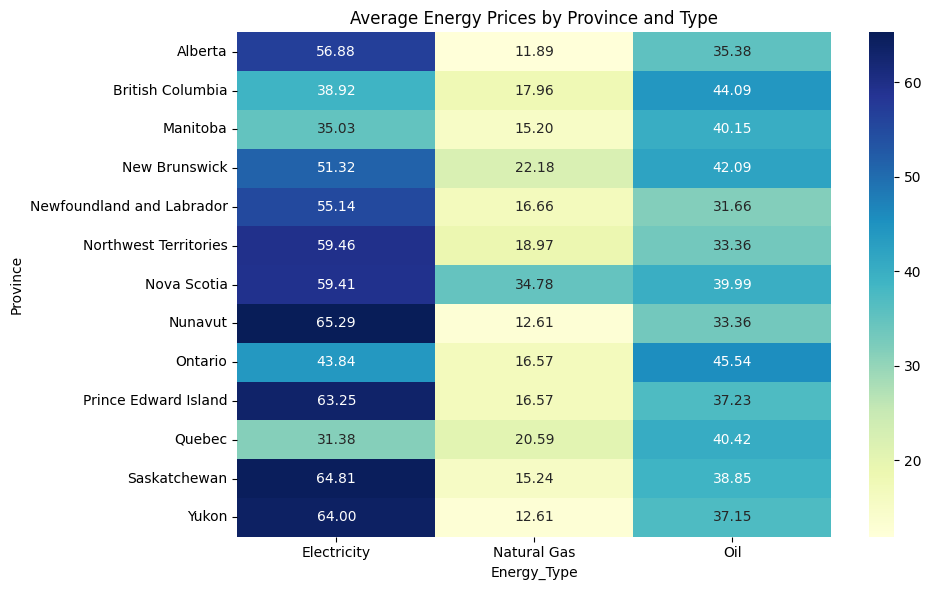

In [ ]:
# Use prices_df 
print(prices_clean.columns.tolist())

# Average energy prices (electricity, gas, oil) by province
def get_avg_price_by_province(df):
    return df.groupby(["Province", "Year", "Energy_Type"], as_index=False).agg({"Price": "mean"})

# Normalize if needed (e.g., per kWh, per GJ)

# Correlate prices with:
#     Demand
#     Generation mix
#     Imports/exports
display_price_boxplot = True
display_price_heatmap = True



# Potential stuff to show data 
# - Boxplot of prices per province
# - Heatmap: prices vs. energy source
# Boxplot of prices per province/type
if display_price_boxplot:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=prices_clean, x="Province", y="GWh", hue="Energy_Type")
    plt.title("Energy Prices by Province and Type")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Heatmap: average price by province and type
if display_price_heatmap:
    pivot = prices_clean.pivot_table(index="Province", columns="Energy_Type", values="GWh", aggfunc="mean")

    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title("Average Energy Prices by Province and Type")
    plt.tight_layout()
    plt.show()


### Visualize trends over time for various regions

In [ ]:
# Use all dataframes - generation_df, capacity_df, demand_df, prices_df, population_yearly_df...

# TODO - Whats needed to be done

# Increasing/decreasing demand

# Shifts in generation mix (e.g., coal to renewables)

# Changes in price

# Population impact


# Potential stuff to show data 
# - Multi-line chart: demand or generation trends by province
# - Sankey diagram (optional): flow from source to usage

### Identify challenges and opportunities

In [ ]:
# Big picture

# TODO - Whats needed to be done

# High prices vs. low prices

# Net exporters vs. importers

# Renewable vs. non-renewable

# Poor vs. rich provinces



# Potential stuff to show data
# - Scatter plot: price vs. generation mix
# - Bubble chart: population vs. generation vs. price
# - Heatmap: correlation matrix of all variables
# - Map: energy mix by province